# Abstract

(Just a sketch) Green's functions and their fourier transform are very useful entities, due to being directly measurable as physical quantities like the spectral function or the susceptibilty and being able to model complex many-body interactions using two-, three- and four-point functions. Due to these calculations being very costly, an intermediate representation of the Green's functions between matsubara frequency and time domain was developed. An advantage of this is a fast and efficient way to retrieve both function variants. This work compares several simpler approaches to geth the Fourier transform to the one using intermediate representations for two- and three-point functions. Afterwards, it is applied in a practical example.


# Introduction

The code for this work is written in Julia, using the library Fermions.jl. it models concepts for the second quantization like Fock-spaces, operators, solvers and much more for fermionic particles. First, four basic libraries are imported.

In [2]:
using Fermions
using LinearAlgebra
using Fermions.Aux
using Fermions.Models
using Fermions.Propagators
using Plots
using LaTeXStrings


function Hubbard(space::FockSpace, U::Real, t::Real, μ::Real)
    H = Operator(space)
    c = annihilators(space)
    dim = space.nflavours
    if dim == 4
        for i in 1:2
            H += t * c[i+2]'*c[i]
            H += t * c[i]'*c[i+2]
            H -= μ * c[i]' * c[i]
            H -= μ * c[i+2]' * c[i+2]
        end
    else
        for i in 1:dim
            if i >= dim-1
                H += t * c[i]'*c[i-dim+2]
                H += t * c[i-dim+2]'*c[i']
            else
                H += t * c[i+2]'*c[i] #electron hopping
                H += t * c[i]'*c[i+2]
            end
            H -= μ * c[i]' * c[i] #chemical potential
        end
    end
    for i in 1:Int(dim/2)
        H += U * c[2*i-1]'*c[2*i-1]*c[2*i]'*c[2*i] #Coulomb repulsion
    end
    return H
end


Hubbard (generic function with 1 method)

# Three-Point Propagator Function

In [3]:
function G_ABC_n_ord_Lehmann1(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, τ1::Array{T,1},τ2::Array{T,1},β::Real) where T <: Real
    val_arr = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(τ1), j in 1:length(τ2)
        if τ1[i] >= τ2[j]
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
            end
            val_arr[i,j] *= exp(-ϵ_n*(β-τ1[i]))
        else #τ2 > τ1
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
            end
            if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
                val_arr[i,j] *= -1.0*exp(-ϵ_n*(β-τ2[j]))
            else
                val_arr[i,j] *= exp(-ϵ_n*(β-τ2[j]))
            end
        end
    end
    return val_arr
end

function G_ABC_Lehmann1(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real) where T <: Real
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann1 (generic function with 1 method)

We reuse this code for our representation of the analytically transformed Lehmann representation:

In [4]:
function G_ABC_n_ord_Lehmann(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, ω1::Array{T,1},ω2::Array{T,1},β::Real) where T <: Real
    val_arr1 = zeros(length(ω1),length(ω2)) .+ 0im
    val_arr2 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)

        val_arr1[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω2[j]))
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω1[i])*(exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr1[i,j] += product
            #*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
        end
        val_arr1[i,j] *= exp(-ϵ_n*β)
    #end  
    #for i in 1:length(ω1), j in 1:length(ω2)
        
        val_arr2[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω1[i])) 
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω2[j]) * (exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr2[i,j] += product
            #*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
        end
        if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
            val_arr2[i,j] *= -1.0*exp(-ϵ_n*β)
        else
            val_arr2[i,j] *= exp(-ϵ_n*β)
        end
    end
    return val_arr1+val_arr2
end

function G_ABC_Lehmann(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real, n_max1::Integer, n_max2::Integer) where T <: Real
    
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    println(length(ω1))
    println(length(ω2))
    println(length(H_eigene))
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann (generic function with 1 method)

(23, 23)
23
-0.4999543004481038


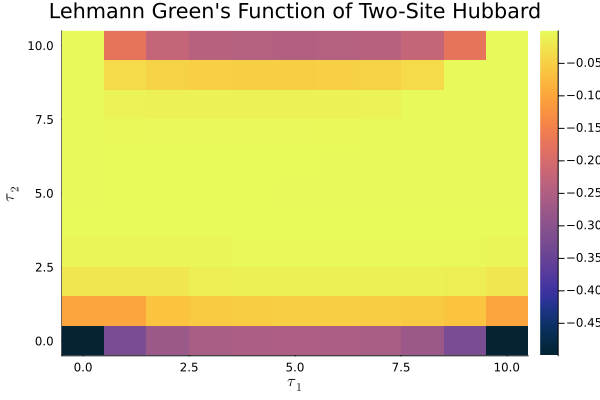

In [165]:
space3 = FockSpace(4)
c3 = annihilators(space3)
#H3 = hubbard_ring_r(space3,3.,-1.,1.5)
H3 = Hubbard(space3,3.,-1.,1.5)
β3 = 10.
A3 = Operator(space3)
A3 += 1.0 * c3[1]
B3 = Operator(space3)
B3 += 1.0 * c3[3]'*c3[3]
C3 = Operator(space3)
C3 += 1.0 * c3[1]'
τ1_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
τ2_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#for i in 1:100
#    push!(τ1_arr,i/10)
#end
G_1b3b1_Lehmann = real(G_ABC_Lehmann1(A3,B3,C3,τ1_arr,τ2_arr,H3,β3)[:,:])
G_1b3b1_00 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0)[:,:])
G_1b3b1_0000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.000001)[:,:])
G_1b3b1_000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.00001)[:,:])
G_1b3b1_00001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0001)[:,:])
G_1b3b1_0001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.001)[:,:])
G_1b3b1_05 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.5)[:,:])
plot(τ1_arr,[G_1b3b1_Lehmann[:,6],G_1b3b1_00[:,6],G_1b3b1_0000001[:,6],G_1b3b1_000001[:,6],G_1b3b1_00001[:,6],G_1b3b1_0001[:,6],G_1b3b1_05[:,6]],title = "G_1b3b1 - τ2 = 5", label = ["Lehmann" "δ=0.0" "δ=10^{-6}" "δ=10^{-5}" "δ=10^{-4}" "δ=10^{-3}" "δ=0.5"], lw = 1, xlabel = "τ1",fmt = :png)


println(size(transform3_Lehmann))
println(length(ω3))
value = G_1b3b1_Lehmann
minval = minimum(value)
println(minval)
heatmap(τ1_arr, τ2_arr, (value), 
    c=cgrad(:thermal),
    title = "Lehmann Green's Function of Two-Site Hubbard", 
    lw = 1, xlabel = L"τ_1", ylabel =  L"τ_2", fmt = :png)

23
23
16
 18.810849 seconds (31.47 M allocations: 9.549 GiB, 17.12% gc time, 6.41% compilation time)


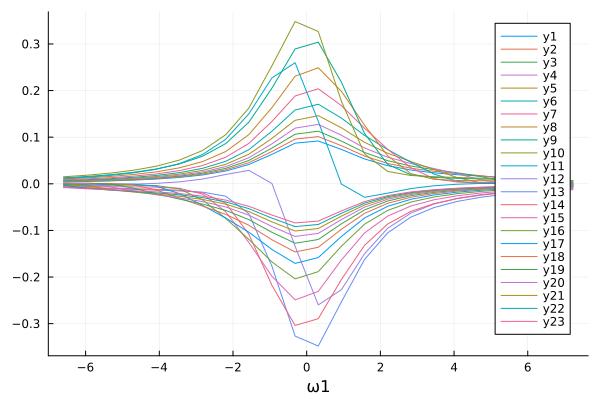

In [6]:
n_max3 = 11
n_max = n_max3
n3 = collect(-n_max:1:n_max)
n=n3
β = β3
ω3 = (2n.+1)*π/β

@time lehmann3 = G_ABC_Lehmann(A3,B3,C3,τ1_arr,τ2_arr,H3,β3, n_max3, n_max3)[:,:]
transform3_Lehmann = imag(lehmann3)
transform3_Lehmann_real = real(lehmann3)

plot(ω3, transform3_Lehmann, lw = 1, xlabel = "ω1",fmt = :png)

(23, 23)
23
-0.34809045430728647


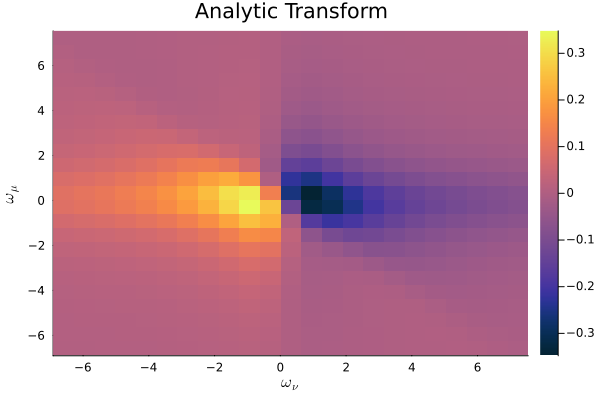

In [163]:
#plot(ω3, ω3, transform3_Lehmann, st=:surface)
println(size(transform3_Lehmann))
println(length(ω3))
value = transform3_Lehmann
minval = minimum(value)
println(minval)
heatmap(ω3, ω3, (value), 
    c=cgrad(:thermal),
    title = "Analytic Transform", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)

Again: Integral as a Sum

\begin{align}
    G(\omega_{\nu}, \omega_{\mu}) \approx \sum_{l} \sum_{j} e^{i \omega_{\nu} \tau_l} e^{i \omega_{\mu} \tau_j} G(\tau_l, \tau_j) \Delta \tau_j \Delta \tau_l
\end{align}

In [8]:
# goal 1 again
function G_ABC_transform(A, B, C, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    Δτ1 = (β/size(τ_arr1)[1])
    Δτ2 = (β/size(τ_arr2)[1])
    
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1))
    result = Δτ1*matrix1*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)
    
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2))
    result = Δτ2*matrix2*transpose(result)
    return transpose(result)
end


function G_ABC_transform_saved(G_THREE, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    dimtau1 = size(τ_arr1)[1]
    dimtau2 = size(τ_arr2)[1]
    dimG1 = size(G_THREE)[1]
    dimG2 = size(G_THREE)[2]  
    stepsizet1 = max(trunc(Int,dimG1/dimtau1),1)
    stepsizet2 = max(trunc(Int,dimG2/dimtau2),1)
    stepsizeinv1 = max(trunc(Int,dimtau1/dimG1),1)
    stepsizeinv2 = max(trunc(Int,dimtau2/dimG2),1)
    
    Δτ1 = (β/size(τ_arr1[begin:stepsizeinv1:end])[1])
    Δτ2 = (β/size(τ_arr2[begin:stepsizeinv2:end])[1])
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1[begin:stepsizeinv1:end]))
    result = Δτ1*matrix1*G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2[begin:stepsizeinv2:end]))
    result = Δτ2*matrix2*transpose(result)
    #println((Δτ1))
    #println(size(matrix1))
    #println(size(G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]))
    #println(size(result))
    return transpose(result)
end

G_ABC_transform_saved (generic function with 1 method)

In [9]:
# make delta tau smaller!
τ_arr = collect(0.:0.05:β-0.05)

@time greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
@time transform3 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

plot(ω,transform3,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

  8.678787 seconds (27.55 M allocations: 4.030 GiB, 13.89% gc time)
  3.673398 seconds (5.40 M allocations: 264.410 MiB, 2.35% gc time, 99.88% compilation time)


LoadError: UndefVarError: ω not defined

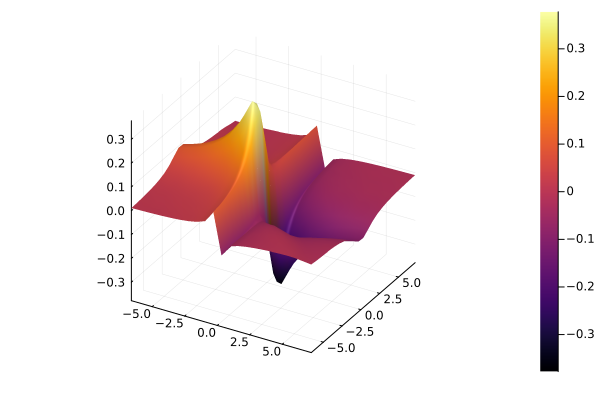

In [10]:
plot(ω3, ω3, transform3, st=:surface)



In [11]:
τ_arr = collect(0.:0.001:β-0.001)

##greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
   





10000-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 9.988
 9.989
 9.99
 9.991
 9.992
 9.993
 9.994
 9.995
 9.996
 9.997
 9.998
 9.999

In [12]:

τ_arr = collect(0.:0.1:β-0.1)
transform3_0_1 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.05:β-0.05)
transform3_0_05 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.01:β-0.01)
transform3_0_01 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))


τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001_real = real(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

x_cut = 25

plot(ω3, transform3_0_1[x_cut,:], label = ["100 points"])
plot!(ω3, transform3_0_05[x_cut,:], label = ["200 points"])
plot!(ω3, transform3_0_01[x_cut,:], label = ["1000 points"])
#plot!(ω3, transform3_0_001[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann[x_cut,:], label = ["analytical"])

println(size(transform3_Lehmann))

LoadError: BoundsError: attempt to access 23×23 Matrix{Float64} at index [25, 1:23]

## 

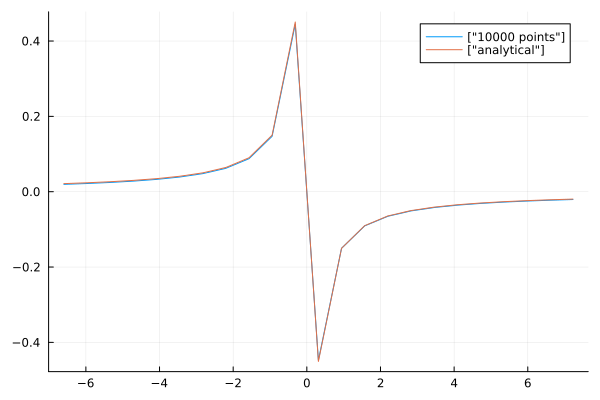

In [13]:
x_cut = 1

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

In [14]:
x_cut = 25

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: BoundsError: attempt to access 23×23 Matrix{Float64} at index [25, 1:23]

In [15]:
x_cut = 50

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: BoundsError: attempt to access 23×23 Matrix{Float64} at index [50, 1:23]

In [16]:
x_cut = 75

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: BoundsError: attempt to access 23×23 Matrix{Float64} at index [75, 1:23]

In [17]:
x_cut = 100

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: BoundsError: attempt to access 23×23 Matrix{Float64} at index [100, 1:23]

In [18]:

value = 
minval = minimum(value)
println(minval)
heatmap(ω3, ω3, (value), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Difference - 3p transform Grundmann Möller", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)

-6.5973445725385655


LoadError: BoundsError: attempt to access 23-element Vector{Float64} at index [25]

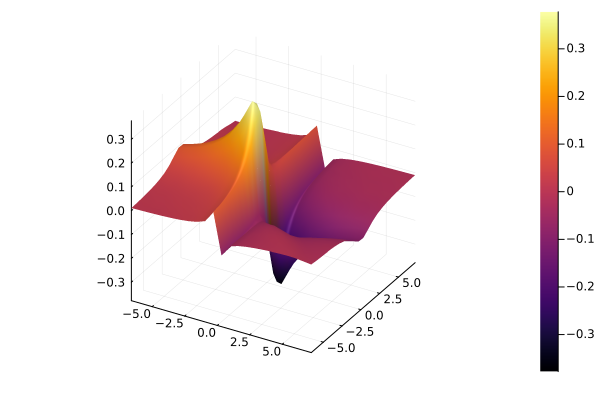

In [19]:
plot(ω3, ω3, transform3_0_001, st=:surface)

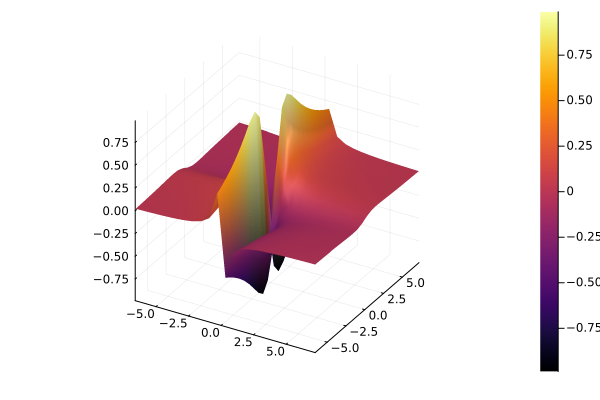

In [20]:
plot(ω3, ω3, transform3_Lehmann_real, st=:surface)

Goal 2: Integral with Gauss-Legendre but 2D, something like:

\begin{align}
    G(i \omega_n) \approx \sum_{j} \omega_j e^{i \omega_n \tau_j} G(\tau_j) \Delta \tau
\end{align}

In [21]:
# goal 2

using Cuba, SpecialFunctions

function G_ABC_gl_part(A, B, C, ham_eb, β, space, ω1, ω2)
    function integrand(x, f)
        #println(G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.05)[1,1])
        #println(full_tau((A,B,C), [(x[1]*β,x[2]*β)], ham_eb, β)[1,1])
        temp=cis(ω2*(x[2]*β))*cis(ω1*(x[1]*β))*G_ABC(A,B,C,[x[1]*β],[x[2]*β],ham_eb,β,space,0.05)[1,1]
        #temp=ℯ.^(im*ω2*(x[2]*β))*ℯ.^(im*ω1*(x[1]*β))*full_tau((A,B,C), [(x[1]*β,x[2]*β)], ham_eb, β)[1,1]
        f[1],f[2]=reim(temp)
    end
    #result, err = cuhre(integrand, 2, 2, atol=1e-12, rtol=1e-10);
    result, err = cuhre(integrand, 2, 2, atol=1e-3, rtol=1e-1);
    return complex(result[1],result[2])
end

function G_ABC_gl_transform(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    τ_arr_expl = collect(0.:0.01:β-0.01)
    
    quantum_numbers = NullSet(space)
    ham_eb = H#Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, β)

    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    
            I = G_ABC_gl_part(A, B, C, ham_eb, β, space, ω1[j], ω2[k])
            #I=4
            println("Done with ", j, ", ", k)
            flush(stdout)
            result[j,k] = I
        end
    end
    
    return result
end


G_ABC_gl_transform (generic function with 1 method)

In [22]:

using Cuba, SpecialFunctions

#@time transform3_cuhre = (G_ABC_gl_transform(A3, B3, C3, H3, β3, space3, n_max3, n_max3))

transform3_cuhre_imag = imag(transform3_cuhre)

LoadError: UndefVarError: transform3_cuhre not defined

In [23]:
plot(ω3, ω3, imag(transform3_cuhre), st=:surface)


LoadError: UndefVarError: transform3_cuhre not defined

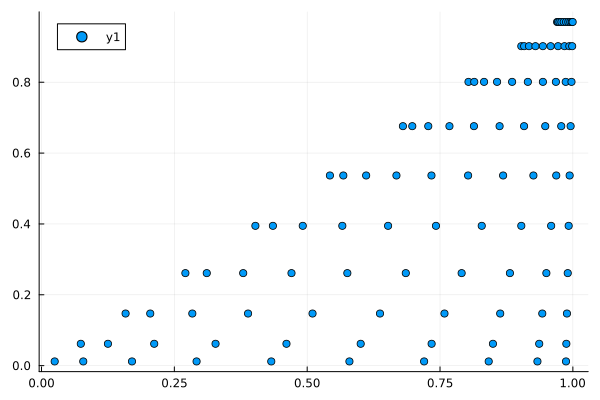

In [24]:
using SimplexQuad

X, W = simplexquad(10, 2)

function f(x,y)
    return sin.(x.*5).+y
end

#Integral = sum(W[i] * f(1 .-X[i,:]) for i in 1:length(W))

Y=1 .-X
#plot(1 .-Y[:,1],Y[:,2],seriestype=:scatter)

plot(1 .-X[:,1],X[:,2],seriestype=:scatter)

#Y[:,:]
#sum(W[i] * f(1 .-Y[i,1], Y[i,2]) for i in 1:length(W))+sum(W[i] * f(1 .-X[i,1],X[i,2]) for i in 1:length(W))

#using PyPlot;
#surf(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]))
#surf(1 .-Y[:,1], Y[:,2], f(1 .-Y[:,1],Y[:,2]))



#plot(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]), st=:surface)
#plot!(1 .-Y[:,1], Y[:,2], f(1 .-Y[:,1],Y[:,2]), st=:surface)


#using PyPlot;
#surf(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]))
#surf(vcat(1 .-X[:,1],1 .-Y[:,1]), vcat(X[:,2],Y[:,2]), vcat(f(1 .-X[:,1],X[:,2]),f(1 .-Y[:,1],Y[:,2])))

#sum(W[i] * f(1 .-Y[i,1], Y[i,2]) for i in 1:length(W))+sum(W[i] * f(1 .-X[i,1],X[i,2]) for i in 1:length(W))


plot(1 .-X[:,1],X[:,2],seriestype=:scatter)

In [25]:
# split the area into two simplices - SimplexQuad

using SimplexQuad

function G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1, ω2, τ_arr1, τ_arr2, weights, ham_eb)
    
    f_vector = Array{typeof(zero(ComplexF64)), 1}(undef,length(τ_arr1))
    
    for f in 1:length(f_vector) 
        f_vector[f] = 0
    end
    
    tautau = []
    for f in 1:length(f_vector)
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        push!(tautau, (τ_1*β,τ_2*β))
    end
    
    matrix2 = full_tau((A,B,C), tautau, ham_eb, β) 
    
    for f in 1:length(f_vector) 
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]

        f_vector[f] = ℯ.^(im*ω1*τ_1*β)* matrix2[f] * ℯ.^(im*ω2*τ_2*β)
    end
    
    return dot(weights*β*β,f_vector)  
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2, npoints)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    X, W = simplexquad(npoints, 2)
    Y=1 .-X
    
    
    quantum_numbers = NullSet(space)
    ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, β)
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    

            values1 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-X[:,1],X[:,2],W, ham_eb)
            values2 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-Y[:,1],Y[:,2],W, ham_eb)
            integral = values1+values2

            result[j,k] = integral
        end
    end
    #result = integral
    return -result
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    npoints = 50
    #npoints = 10
    G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2, npoints)
end


G_ABC_gl_transform_simplex (generic function with 2 methods)

In [26]:
@time transform3_simplex_split = G_ABC_gl_transform_simplex(A3, B3, C3, H3, β3, space3, n_max3, n_max3)


 17.546612 seconds (26.52 M allocations: 1.651 GiB, 8.27% gc time, 49.81% compilation time)


23×23 Matrix{ComplexF64}:
  0.0214543+0.00415197im   …  -0.0195887-0.00735354im
  0.0233865+0.00504484im      -0.0213529-0.0107339im
   0.025661+0.00624008im      -0.0234296-0.0128701im
  0.0283586+0.00788348im      -0.0258927-0.0148317im
  0.0315722+0.0102156im       -0.0288268-0.0173326im
  0.0353827+0.0136509im    …  -0.0323059-0.0209486im
  0.0397685+0.0189324im       -0.0363103-0.0264231im
  0.0442878+0.0274196im       -0.0404366-0.0349377im
  0.0470437+0.0414255im        -0.042953-0.0482207im
  0.0420605+0.0632314im       -0.0384031-0.0670664im
  0.0186401+0.0871868im    …  -0.0170193-0.0839193im
 -0.0186401+0.0918042im        0.0170193-0.0799803im
 -0.0420605+0.0737009im        0.0384031-0.0581518im
 -0.0470437+0.053282im          0.042953-0.0381614im
 -0.0442878+0.0388521im        0.0404366-0.0252855im
 -0.0397685+0.0295923im    …   0.0363103-0.01747im
 -0.0353827+0.0236215im        0.0323059-0.0126013im
 -0.0315722+0.0196055im        0.0288268-0.00943234im
 -0.0283586+0.016588

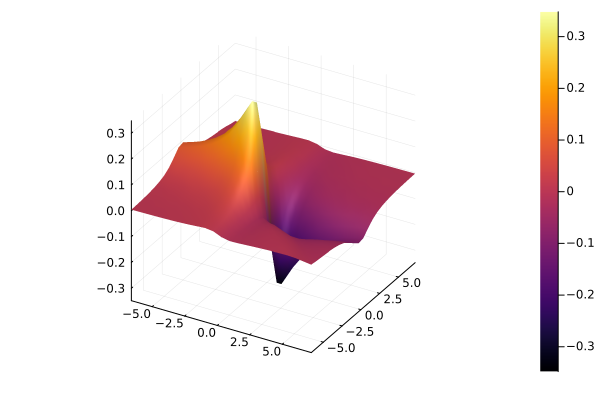

In [27]:
plot(ω3, ω3, imag((transform3_simplex_split)), st=:surface)

[ Info: Saved animation to C:\Users\Markus\git\HubbardIR\tmp.gif


Plots.AnimatedGif("C:\\Users\\Markus\\git\\HubbardIR\\tmp.gif")
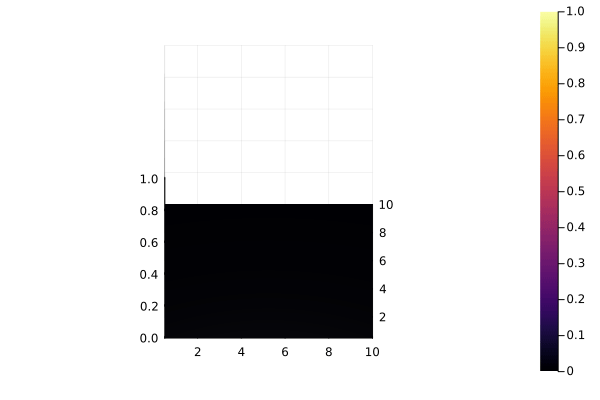

In [168]:
L = 20 
quantum_numbers = NullSet(space3)
ham_eb = Fermions.Propagators.HamiltonianEigen(H3, quantum_numbers, β3)
tautau = []
tau = []
for i in 1:L
    τ_1= i/L
    push!(tau, τ_1)
end
values = []
valuesmat = Array{Float64}(undef, L, L)
for i in 1:L
    for j in 1:L
        τ_1= i/L
        τ_2= j/L
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        val = -full_tau((A3,B3,C3), [(τ_1*β,τ_2*β)], ham_eb, β3)[1,1]
        push!(tautau, (τ_1*β3,τ_2*β3))
        push!(values, val)
        valuesmat[i,j] = val
    end
end

#matrix2 = full_tau((A3,B3,C3), tautau, ham_eb, β3) 
n = 50
@gif for i in range(0, stop = 2π, length = n)
    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    #println(i)
    plot(first.(tautau), last.(tautau), real((values)), st=:surface, camera = (360*i/(2π), 40))
end

#matrix2.-values

#=
matrix2 = G_ABC_Lehmann1(A3,B3,C3,τ1_arr,τ2_arr,H3,β3)[:,:]
n = 50
@gif for i in range(0, stop = 2π, length = n)
    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    #println(i)
    plot(τ1_arr, τ2_arr, real((matrix2)), st=:surface, camera = (360*i/(2π), 40))
end
=#
#=

#heatmap(tau, tau, -real.((valuesmat)), c = :thermal)
display(fieldnames(TnScheme))
#println((scheme.weights))
println((scheme.points))
    tautau = []
    for f in 1:length(scheme.weights)
        τ_1= scheme.weights[f]
        τ_2= scheme.weights[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        push!(tautau, (τ_1*β,τ_2*β))
    end
    threepfunc = full_tau((A3,B3,C3), tautau, ham_eb, β3)
    dict = Dict()
    for (n, f) in enumerate(tautau)
       dict[n] = f
    end

=#

In [29]:
using GrundmannMoeller

vertices = [[0,0], [1,0], [1,1]]
plot(first.(vertices), last.(vertices),seriestype=:scatter)
vertices = [[0,0], [0,1], [1,1]]
plot!(first.(vertices), last.(vertices),seriestype=:scatter)
#
#vertices = [[0,0], [1,0], [0,1]]
#scheme = grundmann_moeller(Float64, Val(2), 5);length(scheme.weights)
#f(x) = exp(im*x[1])
#q = integrate(f, scheme, vertices)

#transform3_simplex_split_gm[11,11]
#transform3_simplex_split[11,11]

plot(first.(list1), last.(list1),seriestype=:scatter)
plot!(first.(list2), last.(list2),seriestype=:scatter)


LoadError: UndefVarError: list1 not defined

In [103]:
# split the area into two simplices - GrundmannMoeller

using GrundmannMoeller

list1 = []
list2 = []

function G_ABC_gm_part_simplex_array1(A, B, C, H, β, space, ω1, ω2, scheme, vertices, ham_eb)
    function f(x) 
        if length(list1) < 600
            append!(list1, [[x[1], x[2]]])
        end
        ℯ.^(im*ω1*(x[1]*β))*full_tau((A,B,C), [(x[1]*β,x[2]*β)], ham_eb, β)[1,1]*ℯ.^(im*ω2*(x[2]*β))*β^2
    end 
    q = integrate(f, scheme, vertices)
    #println(q)
    return q
end
function G_ABC_gm_part_simplex_array2(A, B, C, H, β, space, ω1, ω2, scheme, vertices, ham_eb)
    function f(x) 
        if length(list2) < 600
            append!(list2, [[x[1], x[2]]])
        end
        ℯ.^(im*ω1*(x[1]*β))*full_tau((A,B,C), [(x[1]*β,x[2]*β)], ham_eb, β)[1,1]*ℯ.^(im*ω2*(x[2]*β))*β^2
    end 
    q = integrate(f, scheme, vertices)
    #println(q)
    return q
end

# function is used like simplex quad
function G_ABC_gm_part_simplex_array(A, B, C, H, β, space, ω1, ω2, scheme, vertices, ham_eb)
    
    function f(x) 
        ℯ.^(im*ω1*(x[1]*β))*full_tau((A,B,C), [(x[1]*β,x[2]*β)], ham_eb, β)[1,1]*ℯ.^(im*ω2*(x[2]*β))*β^2
    end

    q = integrate(f, scheme, vertices)
    return q
end

# function plus matrix
function G_ABC_gm_part_collect_points(scheme, vertices)
    list = []
    function f(x) 
        push!(list,(x[1], x[2]))
        0
    end

    q = integrate(f, scheme, vertices)
    return list
end

function G_ABC_gm_transform_simplex(A, B, C, H, β, space, n_max1, n_max2, npoints)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    if(iseven(npoints))
       npoints = npoints + 1
       print("ONLY EVEN NPOINTS, INCREASING +1 TO npoints = ")
       println(npoints)
    end
    scheme = grundmann_moeller(Float64, Val(2), npoints);
    print("length: ")
    println(length(scheme.weights))
    
    quantum_numbers = NullSet(space)
    ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, β)
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)  

            values1 = G_ABC_gm_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], scheme,[[0,0], [1,0], [1,1]], ham_eb)
            values2 = G_ABC_gm_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], scheme,[[0,0], [0,1], [1,1]], ham_eb)
            integral = values1-values2
            
            result[j,k] = integral
        end
    end
    return -result, 2*length(scheme.weights)
end

function G_ABC_gm_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    #npoints = 20
    npoints = 30
    res, npoints = G_ABC_gm_transform_simplex(A, B, C, H, β, space, n_max1, n_max2, npoints)
    return res
end

function cutOffResonanceGR(transform3_simplex_split_gm, corerange)
    transform3_simplex_split_gm1 = copy(transform3_simplex_split_gm)
    x1 = Integer(round(size(transform3_simplex_split_gm1)[1]/2))
    y1 = Integer(round(size(transform3_simplex_split_gm1)[2]/2))
    #corerange = 5
    max1 = maximum((transform3_simplex_split_gm1[x1-corerange:x1+corerange,y1-corerange:y1+corerange]))
    min1 = minimum((transform3_simplex_split_gm1[x1-corerange:x1+corerange,y1-corerange:y1+corerange]))
    transform3_simplex_split_gm1[(transform3_simplex_split_gm1) .> max1] .= 0
    transform3_simplex_split_gm1[(transform3_simplex_split_gm1) .< min1] .= 0
    return transform3_simplex_split_gm1
end



cutOffResonanceGR (generic function with 1 method)

In [31]:
@time transform3_simplex_split_gm = G_ABC_gm_transform_simplex(A3, B3, C3, H3, β3, space3, n_max3, n_max3)

ONLY EVEN NPOINTS, INCREASING +1 TO npoints = 31
length: 816
 61.476442 seconds (135.68 M allocations: 45.761 GiB, 13.80% gc time, 4.88% compilation time)


23×23 Matrix{ComplexF64}:
  3641.51-309.965im  -420.221-49.3627im  …  -13427.9+150.719im
  3056.03-119.409im  -497.732+27.4564im     -8921.57+72.4121im
  2009.08-39.992im    -397.83+22.081im      -5360.98+58.0342im
  1183.13-33.0079im   -247.04+58.7579im     -2929.19+54.0282im
  588.167+14.4228im  -251.605+73.8067im     -1151.47+52.5269im
 -6.81093+29.5852im  -116.043-158.733im  …   377.194+52.2563im
 -372.114-222.349im    227.15+3.34974im      1986.61+53.0813im
 -612.392-33.3872im  -6.84471+139.433im      4033.05+55.4757im
  -1687.9+91.896im    191.628-65.859im       6977.34+62.6236im
 -2509.77-150.258im   370.186+17.6394im      11147.0+100.208im
 -3459.41+2.56212im   476.288+12.4175im  …   15243.8+198.431im
 -3482.16+60.2199im   483.144-5.89542im      15295.7+218.883im
  -2521.8+55.3474im   346.094-8.63164im      10951.6-227.603im
 -1542.42+47.1038im   204.367-8.1459im       7219.93-134.098im
 -838.245+42.9847im     99.62-7.61124im      4012.21+130.403im
 -327.363+41.0122im   18.7297

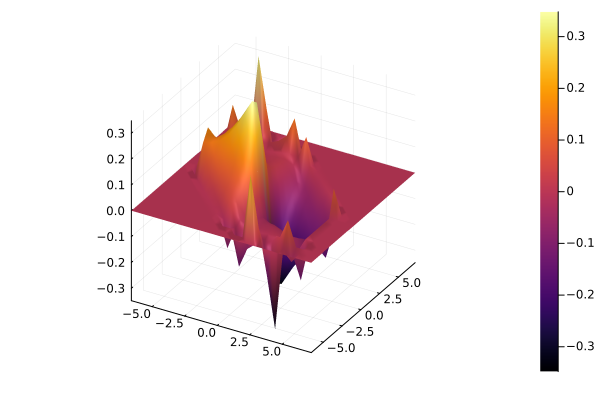

In [32]:
#range1 = 1
#range2 = 22
#plot(ω3[range1:range2], ω3[range1:range2], imag((transform3_simplex_split_gm1[range1:range2,range1:range2])), st=:surface)

transform3_simplex_split_gm1 = cutOffResonanceGR(real(transform3_simplex_split_gm), 2) .+ 
                                im.*cutOffResonanceGR(imag(transform3_simplex_split_gm), 2)

plot(ω3, ω3, imag((transform3_simplex_split_gm1)), st=:surface)

# Analysis

We have now Lehmann again, Naive, Cuhre, Simplex Split, +1?

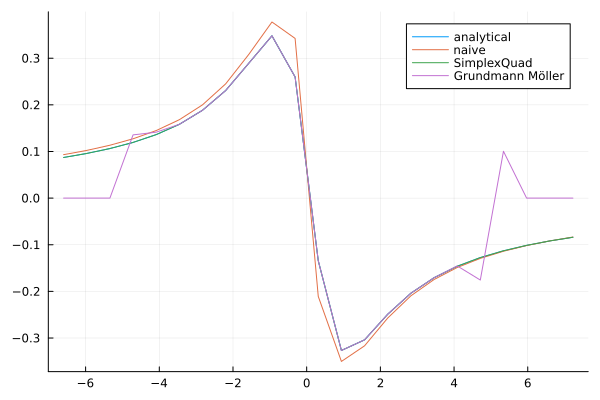

In [65]:
x_cut = Integer(round(n_max))

plot(ω3, transform3_Lehmann[x_cut,:], label = "analytical")
plot!(ω3, transform3[x_cut,:], label = "naive")
plot!(ω3, imag(transform3_simplex_split)[x_cut,:], label = "SimplexQuad")
plot!(ω3, imag(transform3_simplex_split_gm1)[x_cut,:], label = "Grundmann Möller")

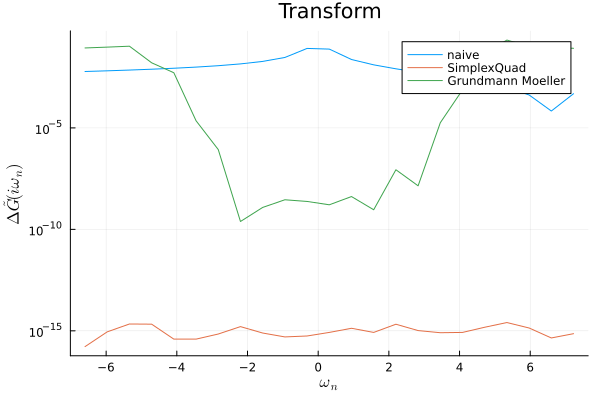

In [34]:
plot(ω3,[abs.(transform3_Lehmann[x_cut,:]-transform3[x_cut,:]), 
         abs.(transform3_Lehmann[x_cut,:]-imag(transform3_simplex_split)[x_cut,:]),
         abs.(transform3_Lehmann[x_cut,:]-imag(transform3_simplex_split_gm1)[x_cut,:])],
    title = "Transform", 
    label = ["naive" "SimplexQuad" "Grundmann Moeller"], 
    yaxis =:log,
    lw = 1, xlabel = L"ω_n", ylabel = L"\Delta\tilde{G}(iω_n)", fmt = :png)

In [98]:
#pyplot();
gr();

value = abs.(transform3_Lehmann-transform3)
minval = minimum(value)
println(minval)
#heatmap(ω3, ω3, (value), 
#    c=cgrad(:thermal), colorbar_scale = :log10)

5.8353576004727126e-6


In [97]:
value = (abs.(transform3_Lehmann-imag(transform3_simplex_split)))
minval = minimum(value)
println(minval)
#heatmap(ω3, ω3, (value), 
#    c=cgrad(:thermal), colorbar_scale = :log10)


4.163336342344337e-17


-0.34809045430728647


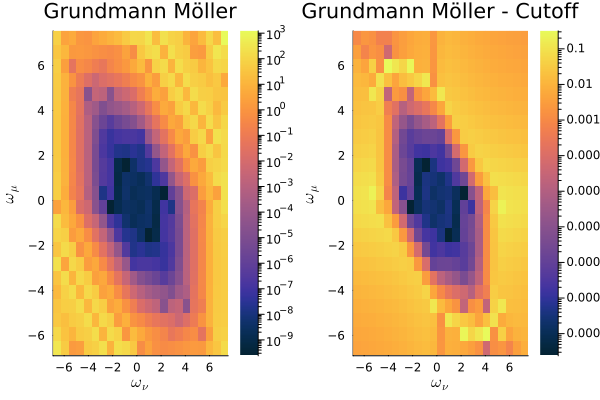

In [139]:
value0 = (abs.(transform3_Lehmann-imag(transform3_simplex_split_gm)))
value1 = (abs.(transform3_Lehmann-imag(transform3_simplex_split_gm1)))
minval = minimum(value)
println(minval)
h0 = heatmap(ω3, ω3, (value0), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Grundmann Möller", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)
h1 = heatmap(ω3, ω3, (value1), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Grundmann Möller - Cutoff", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)
plot(h0,h1,layout = (1,2))

In [44]:
numpointss_Naive = []
errors_Naive = []
#runtime_Lehmann = []
runtime_Naive = []
values_Naive = []

tau_arr_Lehmann = collect(0.:0.05:β-0.05) 
@time transform_Lehmann = (G_ABC_Lehmann(A3, B3, C3, tau_arr_Lehmann, tau_arr_Lehmann, H3, β3, n_max3, n_max3))


for numpoints in 5:5:50
    delta = (β-0)/numpoints
    println(delta)
    # make delta tau smaller!
    tau_arr = collect(0.:delta:β-delta) 
    println(size(tau_arr))
    
    #dt = @elapsed begin
    #end
    #append!(runtime_Lehmann, dt)
    
    ########################################
    
    dt = @elapsed begin
    transform3_Naive = (G_ABC_transform(A3, B3, C3, tau_arr, tau_arr, H3, β3, space3, n_max3, n_max3))
    end
    append!(runtime_Naive, dt)
    append!(values_Naive, [transform3_Naive])
    print("time: ")
    println(dt)
    flush(stdout)
    
    #transform_gl = (G_AB_gl_transform(A, B, H, β, space, n_max))
    #transform_gl2 = (G_AB_gl_transform(A, B, H, β, space, n_max))
    
    error_Naive = maximum(abs.(imag(transform3_Lehmann)-imag(transform3_Naive)))
    
    append!(numpointss_Naive, 2*numpoints^2)
    append!(errors_Naive, error_Naive)
    #println(error_Naive)
end


23
23
16
 13.919273 seconds (30.35 M allocations: 9.495 GiB, 20.06% gc time)
2.0
(5,)
time: 0.0051034
1.0
(10,)
time: 0.0323116
0.6666666666666666
(15,)
time: 0.0747801
0.5
(20,)
time: 0.0854026
0.4
(25,)
time: 0.1627247
0.3333333333333333
(30,)
time: 0.1997674
0.2857142857142857
(35,)
time: 0.2954391
0.25
(40,)
time: 0.3330812
0.2222222222222222
(45,)
time: 0.4611957
0.2
(50,)
time: 0.5842131


In [45]:
numpointss_SimplexSplit = []
errors_SimplexSplit = []
runtime_SimplexSplit = []
values_SimplexSplit = []

for numpoints in 5:5:50
    
    dt = @elapsed begin
    transform_SimplexSplit = G_ABC_gl_transform_simplex(A3, B3, C3, H3, β3, space3, n_max3, n_max3, numpoints)
    end
    append!(runtime_SimplexSplit, dt)
    append!(values_SimplexSplit, [transform_SimplexSplit])
    
    error_SimplexSplit = maximum(abs.(imag(transform_Lehmann)-imag(transform_SimplexSplit)))
    
    append!(numpointss_SimplexSplit, 2*numpoints^2)
    append!(errors_SimplexSplit, error_SimplexSplit)
end

In [83]:
numpointss_SimplexSplitGM = []
errors_SimplexSplitGM = []
runtime_SimplexSplitGM = []
values_SimplexSplitGM = []

for numpoints in [5, 10, 15, 20, 27, 30, 40]
    
    dt = @elapsed begin
    transform_SimplexSplitGM, npointsreal = G_ABC_gm_transform_simplex(A3, B3, C3, H3, β3, space3, n_max3, n_max3, numpoints)
    transform_SimplexSplitGM = cutOffResonanceGR(real(transform_SimplexSplitGM), 2) .+ 
                            im.*cutOffResonanceGR(imag(transform_SimplexSplitGM), 2)
    end
    append!(runtime_SimplexSplitGM, dt)
    append!(values_SimplexSplitGM, [transform_SimplexSplitGM])
    
    error_SimplexSplitGM = maximum(abs.(imag(transform_Lehmann)-imag(transform_SimplexSplitGM)))
    
    append!(numpointss_SimplexSplitGM, npointsreal) # TODO
    append!(errors_SimplexSplitGM, error_SimplexSplitGM)
end

length: 10
ONLY EVEN NPOINTS, INCREASING +1 TO npoints = 11
length: 56
length: 120
ONLY EVEN NPOINTS, INCREASING +1 TO npoints = 21
length: 286
length: 560
ONLY EVEN NPOINTS, INCREASING +1 TO npoints = 31
length: 816
ONLY EVEN NPOINTS, INCREASING +1 TO npoints = 41
length: 1771


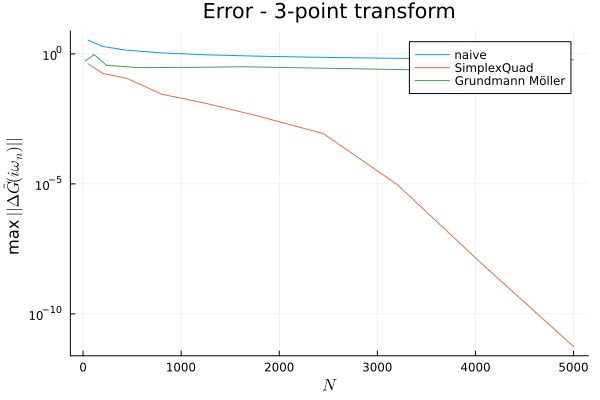

In [84]:
plot([numpointss_Naive],[errors_Naive],
    title = "Error - 3-point transform", 
    label = ["naive" "Simplex Split" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = "max "*L"||\Delta\tilde{G}(iω_n)||", fmt = :png)
plot!([numpointss_SimplexSplit],[errors_SimplexSplit],
    label = ["SimplexQuad" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = "max "*L"||\Delta\tilde{G}(iω_n)||", fmt = :png)
plot!([numpointss_SimplexSplitGM],[errors_SimplexSplitGM],
    label = ["Grundmann Möller" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = "max "*L"||\Delta\tilde{G}(iω_n)||", fmt = :png)

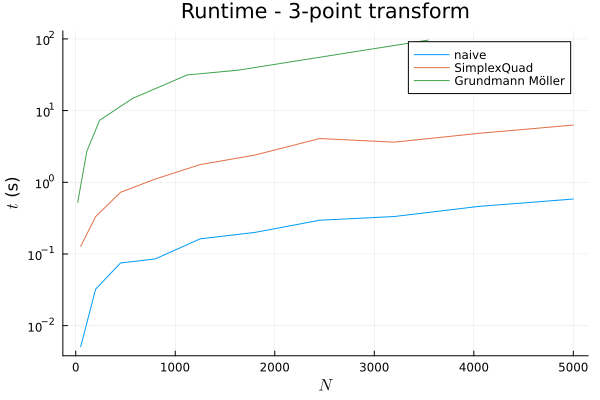

In [87]:
plot([numpointss_Naive],[runtime_Naive],
    title = "Runtime - 3-point transform", 
    label = ["naive" "Gauss-Konrod adaptive" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = L"t"*" (s)", fmt = :png)
plot!([numpointss_SimplexSplit],[runtime_SimplexSplit],
    label = ["SimplexQuad" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = L"t"*" (s)", fmt = :png)
plot!([numpointss_SimplexSplitGM],[runtime_SimplexSplitGM],
    label = ["Grundmann Möller" "Gauss-Legendre"], 
    yaxis =:log,
    lw = 1, xlabel = L"N", ylabel = L"t"*" (s)", fmt = :png)

## Difference Plot

number of points naive: 1250
number of points SimplexQuad: 1250
number of points Grundmann Möller: 1120


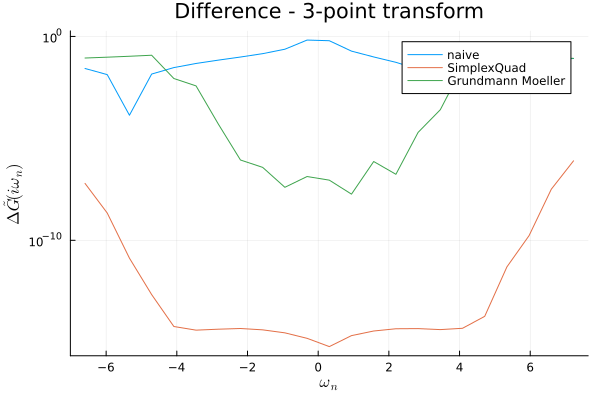

In [86]:
index_Naive = 5
index_SimplexSplit = 5
index_SimplexSplitGM = 5

print("number of points naive: "); println(numpointss_Naive[index_Naive])
print("number of points SimplexQuad: "); println(numpointss_SimplexSplit[index_SimplexSplit])
print("number of points Grundmann Möller: "); println(numpointss_SimplexSplitGM[index_SimplexSplitGM])

plot(ω3,[abs.(transform3_Lehmann[x_cut,:]-imag(values_Naive[index_Naive])[x_cut,:]), 
         abs.(transform3_Lehmann[x_cut,:]-imag(values_SimplexSplit[index_SimplexSplit])[x_cut,:]),
         abs.(transform3_Lehmann[x_cut,:]-imag(values_SimplexSplitGM[index_SimplexSplitGM])[x_cut,:])],
    title = "Difference - 3-point transform", 
    label = ["naive" "SimplexQuad" "Grundmann Moeller"], 
    yaxis =:log,
    lw = 1, xlabel = L"ω_n", ylabel = L"\Delta\tilde{G}(iω_n)", fmt = :png)  


0.0001361645640606951


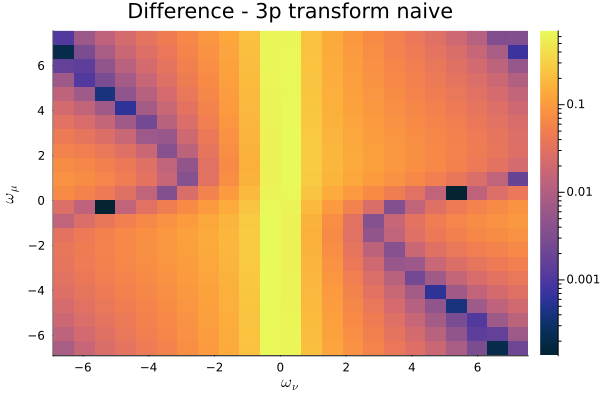

In [118]:
value = abs.(transform3_Lehmann-imag(values_Naive[index_Naive]))
minval = minimum(value)
println(minval)
heatmap(ω3, ω3, (value), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Difference - 3p transform naive", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)

2.0816681711721685e-17


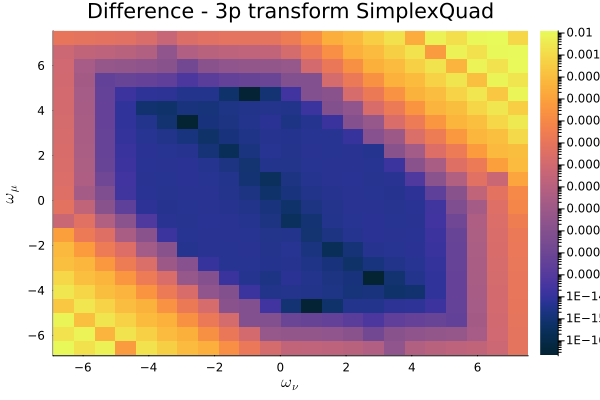

In [119]:
value = abs.(transform3_Lehmann-imag(values_SimplexSplit[index_SimplexSplit]))
minval = minimum(value)
println(minval)
heatmap(ω3, ω3, (value), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Difference - 3p transform SimplexQuad", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)

8.229341513787958e-9


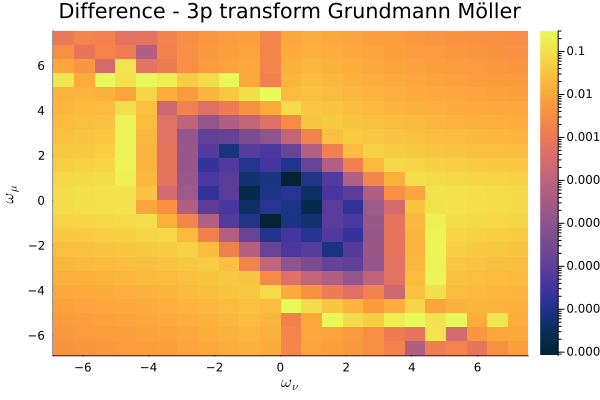

In [120]:
value = abs.(transform3_Lehmann-imag(values_SimplexSplitGM[index_SimplexSplitGM]))
minval = minimum(value)
println(minval)
heatmap(ω3, ω3, (value), 
    c=cgrad(:thermal), colorbar_scale = :log10,
    title = "Difference - 3p transform Grundmann Möller", 
    lw = 1, xlabel = L"\omega_{\nu}", ylabel =  L"\omega_{\mu}", fmt = :png)